In [25]:
# This notebook can be used to analyze a model. ANY model. We are just going to 
# load this model on up, then run the validation data through it, and get make a nice confusion matrix
# from the results :)
#
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras import backend as K 
from keras.layers import Dropout, Flatten, Dense

import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import imageio as io
import cv2 as cv

###################################################
# You put the file names in here                  #
#                                                 #
json_path = './models_json/VGG19_transfer[m1]_3.json'
weights_path = './weights/VGG19_transfer[m1]_3.h5'


# Hardcoded model hyperparameters in for now, may remove
#
def model_factory(json_path, weight_path):
    # Hyperparams
    loss = 'categorical_crossentropy'
    num_units_first_dense = 986 
    dropout_rate = 0.3867433627389078
    num_units_second_dense = 1043
    lr = 0.006072113068495087
    momentum = 0.7963386502886618

    model_json = open(json_path, 'r')
    loaded_model_json = model_json.read()
    model_json.close()
    model = model_from_json(loaded_model_json)
    print('Model loaded from json...')
    
    l = model.output
    l = Flatten()(l)
    l = Dense(num_units_first_dense, activation='relu')(l)
    l = Dropout(dropout_rate)(l)
    l = Dense(num_units_second_dense, activation='relu')(l)
    final = Dense(2, activation='softmax')(l)
    model = Model(inputs=model.input, outputs=final)
    print('Extra layers of model added')
    
    model.load_weights(weight_path)
    print('Model weights loaded from disk...')
    
    model.compile(loss=loss,
                  optimizer=optimizers.SGD(lr=lr, momentum=momentum),
                  metrics=['accuracy'])
    
    return model


model = model_factory(json_path, weights_path)
model.summary()


Model loaded from json...
Extra layers of model added
Model weights loaded from disk...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________

In [26]:
# THIS WILL INPUT A SINGLE IMAGE WHICH WE WILL BE USING TO TEST OUR SLIDING WINDOW CAPABILITIEZZZ 
#
imageName = './test_images/second-first.jpg'
image = cv.imread(imageName)
imageHeight, imageWidth, imageChannels = image.shape


#Parameters to play around with
window_size = 128     #REMEBER TO CHANGE THIS TO 128!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
stride_factor = .5 # Percent of window size to use as convStride


class boxResult:
    x=0
    y=0
    height=0
    width=0
    class_pred=0
    confidence=0.0

    
    
# Input: model to use, image to use, top-left-corner coordinates tuple (x, y), and
#        currentScale
# Output: Single boxResult with dimensions scaled back to the un-scaled
#
def modelPredict(model, predictionImage, tlc, currentScale):
    img_height = predictionImage.shape[0] 
    img_width = predictionImage.shape[1] 
    
    # !!! I AM NOT SURE IF THIS IS SUFFICIENT/CORRECT PRE-PROCESSING
    #      - Also, if we come back and do some extra aspect ratio stuff!!! This will need to be changed 
    #
    predictionImage = np.divide(predictionImage, 255)
    result = model.predict( np.array([predictionImage,]))
    confidence = np.max(result[0]) 
    class_index = np.argmax(result[0]) 
    
    
    temp = boxResult()
    temp.x = int(tlc[0] / currentScale)
    temp.y = int(tlc[1] / currentScale)
    temp.height = int(img_height / currentScale)
    temp.width = int(img_width / currentScale)
    temp.confidence = confidence 
    
    if class_index == 0:
        temp.class_pred = 'car'
    else:
        temp.class_pred = 'non-car'
    
    return temp


#Image info
display("Image " + str(imageName) + " is " + str(imageWidth) + "x" + str(imageHeight) + ".")

# !!! Revisit these scales 
scales = [.25, .5, .75, 1, 1.5, 2, 4]
# scales = [1] # !!! TEMP!!!!!


img_pyramid = []

for scale in scales:
    scaled_img = cv.resize(image, None, fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    img_pyramid.append({'scale': scale, 'img': scaled_img})

# Iterate through scaled_img
#    Iterate through total number of vertical window strides
#       Iterate through total number of horizontal window strides
#          Append prediction with MAPPED coordinates to list  
#
predictions = []
for pyr_layer in img_pyramid:
    img_height = pyr_layer['img'].shape[0]
    img_width =  pyr_layer['img'].shape[1]

    tlc_y = 0
    tlc_x = 0
    print('full height/width: ', img_height, ',  ', img_width)
    
    # !!! Current methodology leaves SLIGHT gaps at bottom of image, revamp later on
    #     with better one
    if img_height > window_size and img_width > window_size: 
        for tlc_y in range(0, (img_height - window_size), int(np.round(window_size * stride_factor))):
            for tlc_x in range(0, (img_width - window_size), int(np.round(window_size * stride_factor))):
                window_img = pyr_layer['img'][tlc_y:(tlc_y + window_size), tlc_x:(tlc_x + window_size), :]
                predictions.append(modelPredict(model, window_img, (tlc_x, tlc_y), pyr_layer['scale']))  
    
            # Make a prediction using the farthest-right-possible x value to cover gap
            window_img = pyr_layer['img'][tlc_y:(tlc_y + window_size), (img_width - window_size):img_width, :]
            predictions.append(modelPredict(model, window_img, (img_width - window_size, tlc_y), pyr_layer['scale'])) 
            
print(len(predictions))

'Image ./test_images/second-first.jpg is 640x360.'

full height/width:  90 ,   160
full height/width:  180 ,   320
full height/width:  270 ,   480
full height/width:  360 ,   640
full height/width:  540 ,   960
full height/width:  720 ,   1280
full height/width:  1440 ,   2560
1168


15


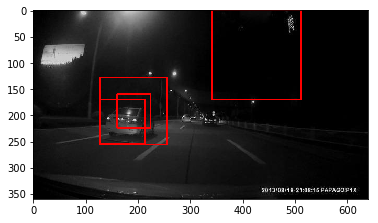

In [24]:
# This will be a great animation for our presentation! Come back to this
#
#
storageImage = image 
displayImage = image 
prevHeight = 0
lineColor = (255,0,0)
lineWidth = 2

# Uncomment out this line if you want to see ONLY the animation of the car-detected sliding windows
# Otherwise, 
#
predictions = [pred for pred in predictions if pred.class_pred == 'car']
temp_pred = [pred for pred in predictions if pred.confidence > .97]
print(len(predictions))


plt.imshow(image)
plt.show()


# for box in temp_pred:
#     cv.rectangle(displayImage,(box.x,box.y),(box.x+box.width,box.y+box.height),lineColor,lineWidth)
#     cv.imshow('Windows',displayImage)
#     cv.waitKey(500)
#     displayImage = storageImage.copy()
# cv.destroyAllWindows()

